Checking results

In [18]:
import torch
from utils import set_seed
from dataset import *
from transforms import Transforms
from models import VideoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/mussi/miniconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/mussi/miniconda3/envs/mestrado/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# ckpt_path = "/mnt/G-SSD/BRACIS/BRACIS-2024/lightning_logs/wlasl/base/WLASL_pretrain_seed_16/version_0/checkpoints/best_model.ckpt"
# ckpt_path = "/mnt/G-SSD/BRACIS/BRACIS-2024/lightning_logs/test_experiment_new_models_v2_seed_16/version_0/checkpoints/best_model.ckpt"

model = VideoModel(

model.eval()
model = model.to(device)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2000]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2000, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
class WLASLDataset(Dataset):
    def __init__(self, dir, split="train", transforms=None):
        self.dir = Path(dir)
        self.split = split
        self.transforms = transforms
        
        self.annotations = pd.read_json(self.dir / "nslt_2000.json").T
        self.annotations["id"] = self.annotations.index
        self.annotations.reset_index(drop=True, inplace=True)
        self.annotations["label"] = self.annotations.action.apply(lambda x: x[0])

        self.missing = self.__get_missing()

        # print(len(self.annotations))
        
        # remove missing indexes from annotations
        self.annotations = self.annotations[~self.annotations['id'].isin(self.missing)]
        print(f'Total after removing missing: {len(self.annotations)}')

        if self.split == "train":
            self.annotations = self.annotations[self.annotations["subset"] != "test"]
            print(f'len train: {len(self.annotations)}')
        else:
            self.annotations = self.annotations[self.annotations["subset"] == "test"]
            print(f'len test: {len(self.annotations)}')
            
        # for videos with if number length < 5 digits, adds 0s in the beggingin to sum up to 5 digits
        self.annotations['id'] = self.annotations['id'].apply(lambda x: f'{x:05}')  
            
            
        self.labels2idx = self.__getlabels()
        self.idx2labels = {v: k for k, v in self.labels2idx.items()}

        self.classes = list(self.labels2idx.keys())

    def __len__(self):
        return len(self.annotations)
    
    def __get_missing(self):
        missing = []
        files = [int(i.split('.')[0]) for i in os.listdir(self.dir / "videos")]
        for filename in self.annotations["id"].values:
            if filename not in files:
                missing.append(filename)
        return missing
    
    def __getlabels(
        self,
    ):
        labels = list(self.annotations["label"].unique())
        labels.sort()
        return {label: i for i, label in enumerate(labels)}

    def __getitem__(self, idx):
        instance = self.annotations.iloc[idx]           
        
        video = torch.load(self.dir / "videos" / f"{instance['id']}.pt")
        
        if self.transforms:
            video = self.transforms(video)

        return video, self.labels2idx[instance["label"]]

In [42]:
# wlasl_train_dataset = WLASLDataset(
#     dir="/mnt/G-SSD/BRACIS/WLASL_tensors_32",
#     split="train",
#     transforms=Transforms(
#         transforms_list=["normalize"],
#         resize_dims=(224, 224),
#         sample_frames=16,
#         random_sample=False,
#         dataset_name="wlasl"
#     ),
# )

wlasl_test_dataset = WLASLDataset(
    dir="/mnt/G-SSD/BRACIS/WLASL_tensors_32",
    split="test",
    transforms=Transforms(
        transforms_list=["normalize"],
        resize_dims=(224, 224),
        sample_frames=16,
        random_sample=False,
        dataset_name="wlasl"
    ),
)

wlasl_val_dataset = WLASLDataset(
    dir="/mnt/G-SSD/BRACIS/WLASL_tensors_32",
    split="val",
    transforms=Transforms(
        transforms_list=["normalize"],
        resize_dims=(224, 224),
        sample_frames=16,
        random_sample=False,
        dataset_name="wlasl"
    ),
)

# wlasl_train_loader = torch.utils.data.DataLoader(
#     wlasl_train_dataset,
#     batch_size=1,
#     shuffle=True,
#     num_workers=8
# )


Total after removing missing: 11980
len test: 1414
Total after removing missing: 11980
len test: 1414


In [43]:
len(wlasl_test_dataset), len(wlasl_val_dataset)

(1414, 1414)

In [25]:
print("All possible label indices in the dataset:", list(wlasl_val_dataset.idx2labels.keys()))
print("All possible label names in the dataset:", list(wlasl_val_dataset.idx2labels.values()))
print("Number of classes in the dataset:", len(wlasl_val_dataset.classes))
print("Number of samples in the dataset:", len(wlasl_val_dataset))
print("Number of samples in the dataloader:", len(wlasl_val_loader))

print("All possible label indices in the dataset:", list(wlasl_train_dataset.idx2labels.keys()))
print("All possible label names in the dataset:", list(wlasl_train_dataset.idx2labels.values()))
print("Number of classes in the dataset:", len(wlasl_train_dataset.classes))
print("Number of samples in the dataset:", len(wlasl_train_dataset))
print("Number of samples in the dataloader:", len(wlasl_train_loader))

All possible label indices in the dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

In [24]:
predictions = []
true_labels = []

i = 0

for i, (x, y) in enumerate(wlasl_val_loader):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        output = model(x)
        pred = torch.argmax(output.logits, dim=1).item()
        
        true_label = y.item()

        # Check if true_label and pred are within valid ranges
        if true_label in wlasl_val_dataset.idx2labels and pred in wlasl_val_dataset.idx2labels:
            print(f"True: {wlasl_val_dataset.idx2labels[true_label]} | Pred: {wlasl_val_dataset.idx2labels[pred]}")
        else:
            print(f"Label mismatch detected. True label: {true_label}, Predicted label: {pred}")
        
        predictions.append(pred)
        true_labels.append(true_label)
        
    i += 1
    if i == 10:
        break


True: 1144 | Pred: 1836
Label mismatch detected. True label: 715, Predicted label: 1678
Label mismatch detected. True label: 126, Predicted label: 1643
True: 352 | Pred: 1509
Label mismatch detected. True label: 800, Predicted label: 1363
True: 1869 | Pred: 131
True: 1308 | Pred: 247
True: 876 | Pred: 1477
Label mismatch detected. True label: 871, Predicted label: 1431
True: 53 | Pred: 208


In [8]:
predictions = []
true_labels = []

with torch.no_grad():
        for data in wlasl_val_dataset:
            video, label = data if len(data) >= 2 else (None, None)
            if video is None:
                raise TypeError(f"Unexpected data type returned from dataset. Expected tuple, got {type(data)}.")
            
            video = video.to(device)
            output = model(video)
            pred = torch.argmax(output.logits, dim=1).item()
            
            predictions.append(pred)
            true_labels.append(label.item())

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average="macro")
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")
cm = confusion_matrix(true_labels, predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
# print("Confusion Matrix:")
# print(cm)

Accuracy: 0.2092
F1 Score: 0.1585
Precision: 0.2318
Recall: 0.1961


/home/mussi/miniconda3/envs/mestrado/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sample 0:
  Label: 14
  Video shape: torch.Size([16, 3, 224, 224])


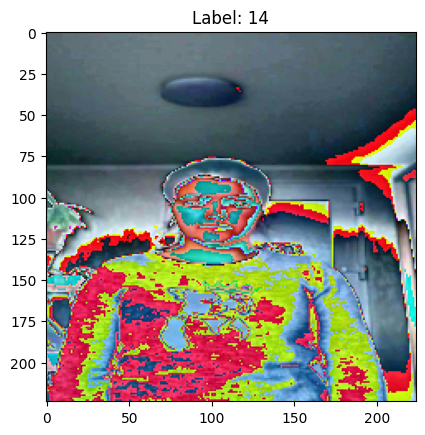

Sample 1:
  Label: 55
  Video shape: torch.Size([16, 3, 224, 224])


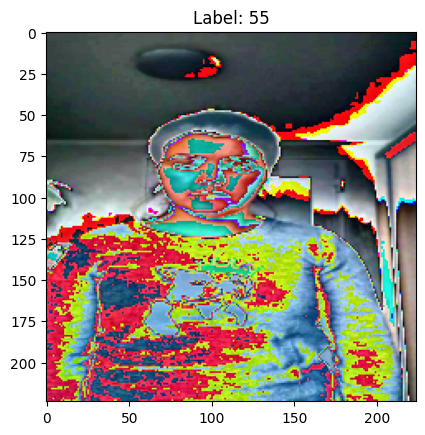

Sample 2:
  Label: 5
  Video shape: torch.Size([16, 3, 224, 224])


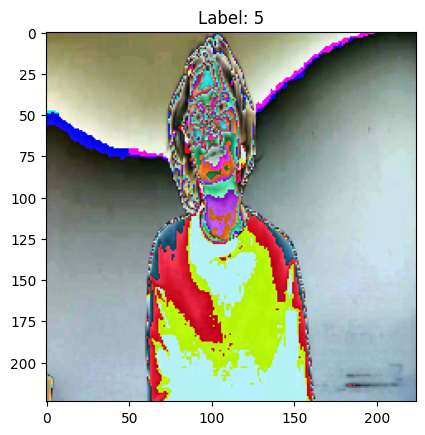

Sample 3:
  Label: 18
  Video shape: torch.Size([16, 3, 224, 224])


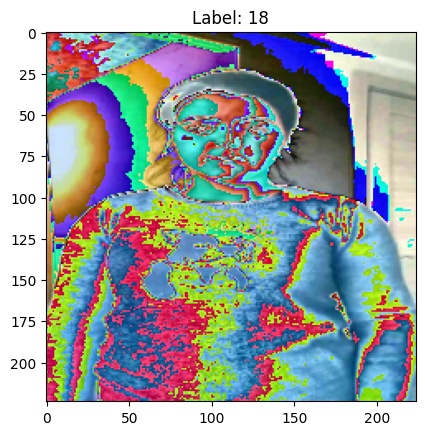

Sample 4:
  Label: 25
  Video shape: torch.Size([16, 3, 224, 224])


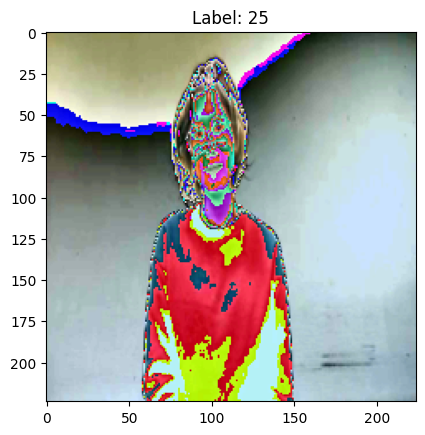

In [9]:
for i in range(5):
    video, label = wlasl_train_dataset[i]
    print(f"Sample {i}:")
    print(f"  Label: {label}")
    print(f"  Video shape: {video.shape}")
    
    first_frame = video[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow((first_frame * 255).astype(np.uint8))
    plt.title(f"Label: {label}")
    plt.show()

In [10]:
predictions = []
true_labels = []

with torch.no_grad():
    for i in range(5):  
        video, label = slovo_val_dataset[i]
        video = video.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        output = model(video)
        pred = torch.argmax(output.logits, dim=1).item()
        
        predictions.append(pred)
        true_labels.append(label)
        
        print(f"Sample {i}:")
        print(f"  True Label: {label}")
        print(f"  Predicted Label: {pred}")

        print(f"  Logits: {output.logits.cpu().numpy()}")


Sample 0:
  True Label: 14
  Predicted Label: 42
  Logits: [[-1.7285358   1.6510799  -0.32845524 ... -1.6559142  -1.9478515
   1.4146063 ]]
Sample 1:
  True Label: 55
  Predicted Label: 35
  Logits: [[ 2.2374687  -1.2086873  -2.5352976  ... -0.23734576 -0.8356915
  -0.8750032 ]]
Sample 2:
  True Label: 5
  Predicted Label: 747
  Logits: [[ 2.0030317  -1.1618285  -0.50486785 ...  0.2764426   0.3418574
  -0.37568   ]]
Sample 3:
  True Label: 18
  Predicted Label: 446
  Logits: [[ 3.3979368 -2.0542865 -0.3496101 ... -1.1969343  1.8489909 -2.0543303]]
Sample 4:
  True Label: 25
  Predicted Label: 218
  Logits: [[ 4.3439665  -0.06379782  0.56131744 ...  0.49063423  0.47610244
  -1.2804923 ]]


## Checking WLASL dataset

In [2]:
import pandas as pd

In [3]:
# reads the json file containing the annotations of the dataset
annotations = pd.read_json("/mnt/G-SSD/BRACIS/WLASL_tensors_32/nslt_2000.json").T

annotations

,subset,action
65097,train,"[481, 1, 74]"
35544,train,"[1164, 1, 68]"
32962,val,"[415, 1, 43]"
30173,test,"[1144, 1, 34]"
35547,val,"[1164, 1, 55]"
...,...,...
15905,val,"[1369, 1, 83]"
38343,train,"[427, 1, 79]"
38342,val,"[427, 1, 86]"
38345,train,"[427, 1, 68]"


In [4]:
# reads the wlasl_class_list.txt in which the first column is the number corresponding to the class and the second column is the class name where there may be spaces between words
classes = pd.read_csv("/mnt/G-SSD/BRACIS/WLASL_tensors_32/wlasl_class_list.txt", sep="\t", header=None)

# creates a dictionary with the class number as key and the class name as value
classes_dict = {int(classes.iloc[i, 0]): classes.iloc[i, 1] for i in range(len(classes))}

classes_dict

{0: 'book',
 1: 'drink',
 2: 'computer',
 3: 'before',
 4: 'chair',
 5: 'go',
 6: 'clothes',
 7: 'who',
 8: 'candy',
 9: 'cousin',
 10: 'deaf',
 11: 'fine',
 12: 'help',
 13: 'no',
 14: 'thin',
 15: 'walk',
 16: 'year',
 17: 'yes',
 18: 'all',
 19: 'black',
 20: 'cool',
 21: 'finish',
 22: 'hot',
 23: 'like',
 24: 'many',
 25: 'mother',
 26: 'now',
 27: 'orange',
 28: 'table',
 29: 'thanksgiving',
 30: 'what',
 31: 'woman',
 32: 'bed',
 33: 'blue',
 34: 'bowling',
 35: 'can',
 36: 'dog',
 37: 'family',
 38: 'fish',
 39: 'graduate',
 40: 'hat',
 41: 'hearing',
 42: 'kiss',
 43: 'language',
 44: 'later',
 45: 'man',
 46: 'shirt',
 47: 'study',
 48: 'tall',
 49: 'white',
 50: 'wrong',
 51: 'accident',
 52: 'apple',
 53: 'bird',
 54: 'change',
 55: 'color',
 56: 'corn',
 57: 'cow',
 58: 'dance',
 59: 'dark',
 60: 'doctor',
 61: 'eat',
 62: 'enjoy',
 63: 'forget',
 64: 'give',
 65: 'last',
 66: 'meet',
 67: 'pink',
 68: 'pizza',
 69: 'play',
 70: 'school',
 71: 'secretary',
 72: 'short',
 7

In [5]:
annotations["label"] = annotations.action.apply(lambda x: x[0])

# adds a new column to the annotations dataframe with the class name corresponding to the class number
annotations["class"] = annotations.label.apply(lambda x: classes_dict[x])

annotations

,subset,action,label,class
65097,train,"[481, 1, 74]",481,art
35544,train,"[1164, 1, 68]",1164,me
32962,val,"[415, 1, 43]",415,lettuce
30173,test,"[1144, 1, 34]",1144,interesting
35547,val,"[1164, 1, 55]",1164,me
...,...,...,...,...
15905,val,"[1369, 1, 83]",1369,determine
38343,train,"[427, 1, 79]",427,night
38342,val,"[427, 1, 86]",427,night
38345,train,"[427, 1, 68]",427,night


In [8]:
annotations.subset.value_counts()

# creates a new dataframe with the number of samples per class
class_counts = annotations.groupby("class").size().reset_index(name="counts")

class_counts

,class,counts
0,a,8
1,a lot,8
2,abdomen,8
3,able,8
4,about,15
...,...,...
1995,you,16
1996,young,12
1997,your,15
1998,yourself,10


In [ ]:
# checks if all the classes in train and val are on test without using 'set'
class_counts_train = annotations[annotations.subset == "train"].groupby("class").size().reset_index(name="counts")

class_counts_test = annotations[annotations.subset == "test"].groupby("class").size().reset_index(name="counts")

class_counts_val = annotations[annotations.subset == "val"].groupby("class").size().reset_index(name="counts")

class_counts_train, class_counts_val, class_counts_test